In [5]:
from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.chains import RetrievalQA
from langchain.llms import OpenAI

from langgraph.graph import StateGraph, END
from typing import Annotated, TypedDict


from dotenv import load_dotenv
import os

load_dotenv()

True

https://medium.com/@lucas.dahan/hands-on-langgraph-building-a-multi-agent-assistant-06aa68ed942f

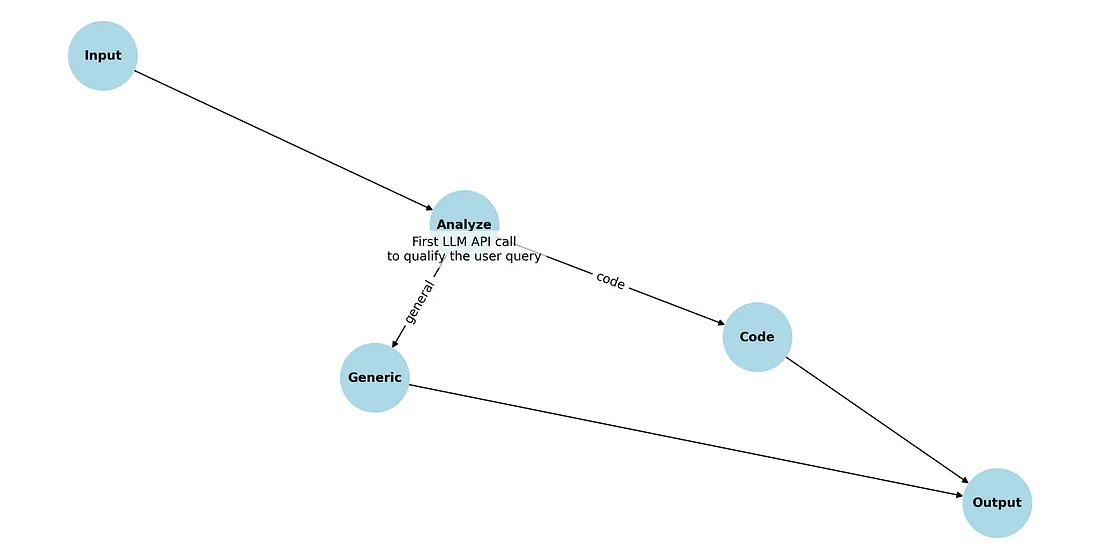


In [11]:
# Creating the first analysis agent to check the prompt structure
# This print part helps you to trace the graph decisions
def analyze_question(state):
    llm = ChatOpenAI()
    prompt = PromptTemplate.from_template(
        """
    You are an agent that needs to define if a question is a technical code one or a general one.

    Question : {input}

    Analyse the question. Only answer with "code" if the question is about technical development. If not just answer "general".

    Your answer (code/general) :
    """
    )
    chain = prompt | llm
    response = chain.invoke({"input": state["input"]})
    decision = response.content.strip().lower()
    return {"decision": decision, "input": state["input"]}


# Creating the code agent that could be way more technical
def answer_code_question(state):
    llm = ChatOpenAI()
    prompt = PromptTemplate.from_template(
        "You are a software engineer. Answer this question with step by steps details : {input}"
    )
    chain = prompt | llm
    response = chain.invoke({"input": state["input"]})
    return {"output": response}


# Creating the generic agent
def answer_generic_question(state):
    llm = ChatOpenAI()
    prompt = PromptTemplate.from_template(
        "Give a general and concise answer to the question: {input}"
    )
    chain = prompt | llm
    response = chain.invoke({"input": state["input"]})
    return {"output": response}

In [12]:

#You can precise the format here which could be helpfull for multimodal graphs
class AgentState(TypedDict):
    input: str
    output: str
    decision: str


#Here is a simple 3 steps graph that is going to be working in the bellow "decision" condition
def create_graph():
    workflow = StateGraph(AgentState)

    workflow.add_node("analyze", analyze_question)
    workflow.add_node("code_agent", answer_code_question)
    workflow.add_node("generic_agent", answer_generic_question)

    workflow.add_conditional_edges(
        "analyze",
        lambda x: x["decision"],
        {
            "code": "code_agent",
            "general": "generic_agent"
        }
    )

    workflow.set_entry_point("analyze")
    workflow.add_edge("code_agent", END)
    workflow.add_edge("generic_agent", END)

    return workflow.compile()


In [13]:

class UserInput(TypedDict):
    input: str
    continue_conversation: bool

def get_user_input(state: UserInput) -> UserInput:
    user_input = input("\nEnter your question (ou 'q' to quit) : ")
    return {
        "input": user_input,
        "continue_conversation": user_input.lower() != 'q'
    }

def process_question(state: UserInput):
    graph = create_graph()
    result = graph.invoke({"input": state["input"]})
    print("\n--- Final answer ---")
    print(result["output"])
    return state

def create_conversation_graph():
    workflow = StateGraph(UserInput)

    workflow.add_node("get_input", get_user_input)
    workflow.add_node("process_question", process_question)

    workflow.set_entry_point("get_input")

    workflow.add_conditional_edges(
        "get_input",
        lambda x: "continue" if x["continue_conversation"] else "end",
        {
            "continue": "process_question",
            "end": END
        }
    )

    workflow.add_edge("process_question", "get_input")

    return workflow.compile()

In [14]:
# Main function
conversation_graph = create_conversation_graph()
conversation_graph.invoke({"input": "", "continue_conversation": True})


--- Final answer ---
content='The capital of Japan is Tokyo.' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 7, 'prompt_tokens': 23, 'total_tokens': 30, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None} id='run-6bf2164b-0dfb-490b-b2a4-a4137dfdc77d-0' usage_metadata={'input_tokens': 23, 'output_tokens': 7, 'total_tokens': 30}

--- Final answer ---
content='1. Import the necessary libraries:\n```python\nimport numpy as np\nimport pandas as pd\nimport statsmodels.api as sm\n```\n\n2. Create a sample data set:\n```python\ndata = pd.Series([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])\n```\n\n3. Calculate the mean using statmodels:\n```python\nmean = sm.tools.tools.mean(data)\nprint("Mean:", mean)\n```\n\n4. Calculate the median using statmodels:\n```python\nmedian = sm.tools.tools.median(data)\nprint("Median:", median)\n```\n\n5. Calculate the mod

{'input': 'q', 'continue_conversation': False}